In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [3]:
#load some data
base_url = "https://raw.githubusercontent.com/NocturneBear/NBA-Data-2010-2024/main/"
files = [
    "regular_season_box_scores_2010_2024_part_1.csv",
    "regular_season_box_scores_2010_2024_part_2.csv",
    "regular_season_box_scores_2010_2024_part_3.csv",
    "play_off_box_scores_2010_2024.csv"
]
dfs = [pd.read_csv(base_url + f) for f in files]

playoffs = dfs[3]
rs1 = dfs[0]
rs2 = dfs[1]
rs3 = dfs[2]

In [43]:
regular = pd.concat([rs1, rs2, rs3], ignore_index=True)
regular['is_playoff'] = 0
playoffs['is_playoff'] = 1

df = pd.concat([regular, playoffs], ignore_index=True)

#format
df.drop(columns=['jerseyNum', 'comment', 'position', 'matchup'], inplace=True)
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

def convert_minutes(min_str):
    try:
        if pd.isna(min_str): return 0
        parts = min_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60 if len(parts) == 2 else 0
    except: return 0

df['minutes_played'] = df['minutes'].apply(convert_minutes)
df.drop(columns=['minutes'], inplace=True)
df['season'] = df['season_year'].str[:4].astype(int)

#data aggs
agg = df.groupby(['personId', 'personName', 'game_date', 'is_playoff']).agg({
    'gameId': 'count',
    'minutes_played': 'sum',
    'points': 'sum',
    'assists': 'sum',
    'reboundsTotal': 'sum',
    'fieldGoalsMade': 'sum',
    'fieldGoalsAttempted': 'sum',
    'threePointersMade': 'sum',
    'freeThrowsMade': 'sum',
    'turnovers': 'sum',
    'plusMinusPoints': 'sum'
}).rename(columns={'gameId': 'games_played'}).reset_index().sort_values('game_date')

agg['ppm'] = (agg['points'] / agg['minutes_played']).dropna()
agg = agg[agg.minutes_played > 0]


# pivoted = agg.pivot_table(index=['personId', 'personName', 'season'], columns='is_playoff',
#                           values=['points', 'minutes_played', 'assists', 'reboundsTotal'], aggfunc='sum')
# pivoted.columns = ['_'.join(map(str, col)) for col in pivoted.columns]
# pivoted = pivoted.dropna()

# #per min stats
# pivoted['ppm_regular'] = pivoted['points_0'] / pivoted['minutes_played_0']
# pivoted['ppm_playoff'] = pivoted['points_1'] / pivoted['minutes_played_1']
# pivoted['residual_ppm'] = pivoted['ppm_playoff'] - pivoted['ppm_regular']


# #resids
# residual_series = pivoted.sort_values(['season', 'personId'])['residual_ppm'].reset_index(drop=True).dropna()

In [167]:
from arch import arch_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def create_features(df):
    df = df.copy()
    df['TS%'] = df['points'] / (2 * (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsMade'] + 1e-5))
    df['AST/TO'] = df['assists'] / (df['turnovers'] + 1e-5)
    df['REB%'] = df['reboundsTotal'] / (df['minutes_played'] + 1e-5)
    df['USG'] = (df['fieldGoalsAttempted'] + 0.44 * df['freeThrowsMade'] + df['turnovers']) / (df['minutes_played'] + 1e-5)
    return df

def rolling_features(df, window=5):
    feats = ['TS%', 'AST/TO', 'REB%', 'USG']
    for f in feats:
        df[f'_roll_{f}'] = df.groupby('personId')[f].transform(lambda x: x.rolling(window, min_periods=1).mean())
    return df

def fit_garchx_oos(player_df, target_col='ppm'):
    """
    1) Use all data with year < 2023 to train the GARCH model.
    2) Produce fitted (predicted) values for the subset with year >= 2023.
    3) Return a DataFrame *only* for the OOS portion, containing predicted diffs.
    """
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LassoCV
    from sklearn.metrics import r2_score
    from arch import arch_model
    
    # ------------------
    # Split into train vs. test (OOS)
    # ------------------
    train_df = player_df.query('year < 2023').copy()
    oos_df   = player_df.query('year >= 2023').copy()
    
    # If not enough training data, bail out
    if len(train_df) < 10:
        return None, None, None, None, None
    
    # ------------------
    # Prepare TRAIN
    # ------------------
    # Drop any rows lacking the target
    train_df = train_df.dropna(subset=[target_col]).copy()

    # Difference the target
    train_df['diff_ppm'] = train_df[target_col].diff()

    # Shift exogenous so we don't leak future info
    feat_cols = [col for col in train_df.columns if col.startswith('_roll_')]
    for c in feat_cols:
        train_df[c] = train_df[c].shift(1)

    # Drop newly introduced NaNs
    train_df.dropna(subset=['diff_ppm'] + feat_cols, inplace=True)
    
    # If still not enough data, stop
    if len(train_df) < 10:
        return None, None, None, None, None

    y_train = train_df['diff_ppm'].values
    X_train = train_df[feat_cols].values
    
    # LASSO for feature selection
    lasso = LassoCV(cv=5).fit(X_train, y_train)
    selected_idx = np.where(lasso.coef_ != 0)[0]
    if len(selected_idx) == 0:
        return None, None, None, None, None
    
    X_train_sel = X_train[:, selected_idx]
    
    # Fit the GARCH(1,1) + ARX(1)
    model = arch_model(
        y_train,
        x=X_train_sel,
        mean='ARX',
        lags=1,
        vol='GARCH',
        p=1, q=1,
        dist='normal'
    )
    res = model.fit(disp='off')
    
    # ------------------
    # In-sample train fitted diffs (just for info)
    # ------------------
    fitted_diff_in = get_in_sample_fitted_values(res, y_train, X_train_sel)
    # We'll compute an in-sample R² on the train portion's differenced data
    from sklearn.metrics import r2_score
    valid_mask = ~pd.isna(fitted_diff_in)
    r2_train = r2_score(y_train[valid_mask], fitted_diff_in[valid_mask]) if np.any(valid_mask) else np.nan
    
    # ------------------
    # Prepare OOS data
    # (Naive: re-difference OOS subset and re-apply the same approach)
    # ------------------
    if len(oos_df) == 0:
        # No OOS data
        return res, lasso, selected_idx, None, r2_train

    # Same differencing & shift for OOS
    oos_df = oos_df.dropna(subset=[target_col]).copy()
    oos_df['diff_ppm'] = oos_df[target_col].diff()
    for c in feat_cols:
        oos_df[c] = oos_df[c].shift(1)
    oos_df.dropna(subset=['diff_ppm'] + feat_cols, inplace=True)
    if len(oos_df) == 0:
        # Means differencing removed all rows
        return res, lasso, selected_idx, None, r2_train

    # Build arrays for the OOS portion
    y_oos = oos_df['diff_ppm'].values
    X_oos = oos_df[feat_cols].values
    X_oos_sel = X_oos[:, selected_idx]

    # ------------------
    # "Predict" OOS diffs
    # ------------------
    # This is a naive approach that uses only the *mean* equation from res.params,
    # ignoring the GARCH recursion on volatility. For a real GARCH forecast,
    # you would typically use res.forecast(..., x=full_exog, last_obs=...).
    #
    # We'll just replicate the "get_in_sample_fitted_values" logic, but feed
    # OOS data to the same ARX parameters. This won't be a true GARCH forecast
    # with updated volatility. See the 'Important Caveat' above.
    #
    fitted_diff_oos = get_out_of_sample_mean_arx(
        res, y_oos, X_oos_sel, y_train[-1]
    )
    oos_df.reset_index(drop=True, inplace=True)
    oos_df['fitted_diff_ppm'] = fitted_diff_oos

    # OOS R² on differenced data
    valid_mask_oos = ~pd.isna(fitted_diff_oos)
    r2_oos = r2_score(oos_df.loc[valid_mask_oos, 'diff_ppm'],
                      oos_df.loc[valid_mask_oos, 'fitted_diff_ppm']) if np.any(valid_mask_oos) else np.nan
    
    return res, lasso, selected_idx, oos_df, r2_oos

def get_in_sample_fitted_values(res, y, X_selected):
    """
    Same as your original: compute the in-sample fitted mean for y_t using:
      y_t = mu + ar.1*y_{t-1} + sum(beta_j * X_{t,j})
    ignoring GARCH volatility.
    """
    import numpy as np
    params = res.params
    mu = params.get('mu', 0.0)
    ar1 = params.get('ar.1', 0.0)

    exog_names = [p for p in params.index if p.startswith('x')]
    exog_coefs = [params[name] for name in exog_names]
    fitted_vals = np.full_like(y, np.nan, dtype=float)
    
    for t in range(1, len(y)):
        mean_t = mu + ar1*y[t-1]
        for j in range(len(exog_coefs)):
            mean_t += exog_coefs[j]*X_selected[t,j]
        fitted_vals[t] = mean_t
    return fitted_vals

def get_out_of_sample_mean_arx(res, y_oos, X_oos_sel, last_y_train):
    """
    Naive approach: For each OOS index t, compute
        yhat(t) = mu + ar.1 * y_{t-1} + sum(beta_j * X_{t,j})
    but y_{t-1} is the *actual or predicted* from the prior step.
    
    We only have the final actual from training for t-1=0.
    Then for subsequent steps, we can EITHER use the newly predicted value
    or remain naive & use the actual y(t-1). If you're fully out-of-sample,
    you typically only have the last actual from the training set, so you
    might do a "recursive" approach. Below, we do a *recursive* approach:
    """
    import numpy as np
    
    params = res.params
    mu = params.get('mu', 0.0)
    ar1 = params.get('ar.1', 0.0)

    exog_names = [p for p in params.index if p.startswith('x')]
    exog_coefs = [params[name] for name in exog_names]

    fitted_vals = np.full_like(y_oos, np.nan, dtype=float)
    
    # We'll keep track of y_{t-1}, starting with the last training observation:
    prev_y = last_y_train
    
    for t in range(len(y_oos)):
        mean_t = mu + ar1 * prev_y
        for j in range(len(exog_coefs)):
            mean_t += exog_coefs[j] * X_oos_sel[t, j]
        fitted_vals[t] = mean_t
        
        # *Recursive* update: assume the actual 'diff' for the next step is the predicted
        # or you might do something else. We'll do "predicted" here:
        prev_y = mean_t  # So next iteration uses predicted diff(t)
    
    return fitted_vals

# -------------------------------------------------------------------
# Example usage in the main loop
# -------------------------------------------------------------------
unique_players = agg.personName.unique()
filtered_out_players = []
player_results = []
all_fitted_results = []

# Preprocessing
agg['game_date'] = pd.to_datetime(agg['game_date'])
agg = agg.sort_values(['personName', 'game_date'])
agg = create_features(agg)
agg = rolling_features(agg)

for player in unique_players:
    sub = agg[agg.personName == player].query('minutes_played > 20')
    if len(sub) < 20:
        filtered_out_players.append(player)
        continue
    
    # Check stationarity (ADF) on level data
    adf_stat, adf_p = adfuller(sub.ppm.dropna())[:2]
    if adf_p > 0.05:
        filtered_out_players.append(player)
        continue
    
    result, lasso, selected, fitted_df, r2_val = fit_garchx_oos(sub)
    if result is None:
        filtered_out_players.append(player)
        continue

    print(f"{player} | ARCH built-in R-squared: {result.rsquared:.3f} | AIC: {result.aic:.2f}")
    print(f"{player} | Manual R² on differenced data: {r2_val:.3f}")
    try:
        fitted_df['personName'] = player
        all_fitted_results.append(fitted_df)
        player_results.append((player, result, r2_val))
    except:
        continue

# Combine all in a single DataFrame (optional)
all_fitted_results_df = pd.concat(all_fitted_results, ignore_index=True)
print(all_fitted_results_df.head(15))


AJ Griffin | ARCH built-in R-squared: 0.238 | AIC: -4.61
AJ Griffin | Manual R² on differenced data: -2.161
Aaron Brooks | ARCH built-in R-squared: 0.296 | AIC: -4.28
Aaron Brooks | Manual R² on differenced data: 0.001
Aaron Gordon | ARCH built-in R-squared: 0.241 | AIC: -51.33
Aaron Gordon | Manual R² on differenced data: -0.003
Aaron Wiggins | ARCH built-in R-squared: 0.436 | AIC: -7.42
Aaron Wiggins | Manual R² on differenced data: -0.055
Adreian Payne | ARCH built-in R-squared: 0.208 | AIC: 6.91
Adreian Payne | Manual R² on differenced data: -0.052
Al Jefferson | ARCH built-in R-squared: 0.241 | AIC: -33.95
Al Jefferson | Manual R² on differenced data: -0.001
Al-Farouq Aminu | ARCH built-in R-squared: 0.241 | AIC: -282.52
Al-Farouq Aminu | Manual R² on differenced data: -0.000
Alec Burks | ARCH built-in R-squared: 0.197 | AIC: -8.47
Alec Burks | Manual R² on differenced data: -0.003
Aleksej Pokusevski | ARCH built-in R-squared: 0.364 | AIC: -21.74
Aleksej Pokusevski | Manual R² on 

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Antawn Jamison | ARCH built-in R-squared: -11.426 | AIC: 1052.20
Antawn Jamison | Manual R² on differenced data: -10.680
Anthony Bennett | ARCH built-in R-squared: 0.685 | AIC: -14.32
Anthony Bennett | Manual R² on differenced data: -0.001
Anthony Edwards | ARCH built-in R-squared: 0.236 | AIC: 23.00
Anthony Edwards | Manual R² on differenced data: 0.001
Anthony Morrow | ARCH built-in R-squared: 0.244 | AIC: -8.60
Anthony Morrow | Manual R² on differenced data: 0.000


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Anthony Parker | ARCH built-in R-squared: -897943.636 | AIC: 5046841.00
Anthony Parker | Manual R² on differenced data: -904495.877
Anthony Randolph | ARCH built-in R-squared: 0.403 | AIC: -5.14
Anthony Randolph | Manual R² on differenced data: 0.011
Anthony Tolliver | ARCH built-in R-squared: 0.198 | AIC: -43.40
Anthony Tolliver | Manual R² on differenced data: -0.001
Antonio McDyess | ARCH built-in R-squared: 0.080 | AIC: -16.78
Antonio McDyess | Manual R² on differenced data: -0.000
Archie Goodwin | ARCH built-in R-squared: 0.110 | AIC: 13.84
Archie Goodwin | Manual R² on differenced data: 0.018
Armoni Brooks | ARCH built-in R-squared: 0.259 | AIC: 2.40
Armoni Brooks | Manual R² on differenced data: -0.004
Austin Reaves | ARCH built-in R-squared: 0.117 | AIC: 3.78
Austin Reaves | Manual R² on differenced data: -0.014
Ayo Dosunmu | ARCH built-in R-squared: 0.339 | AIC: -40.73
Ayo Dosunmu | Manual R² on differenced data: -0.021
Bam Adebayo | ARCH built-in R-squared: -0.268 | AIC: 166.

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Brandon Rush | ARCH built-in R-squared: 0.246 | AIC: -38.96
Brandon Rush | Manual R² on differenced data: 0.000
Brook Lopez | ARCH built-in R-squared: 0.265 | AIC: -79.38
Brook Lopez | Manual R² on differenced data: 0.003
Bruno Fernando | ARCH built-in R-squared: 0.101 | AIC: 11.88
Bruno Fernando | Manual R² on differenced data: -0.043
Buddy Hield | ARCH built-in R-squared: 0.224 | AIC: -61.54
Buddy Hield | Manual R² on differenced data: -0.003
Byron Mullens | ARCH built-in R-squared: 0.201 | AIC: 2.26
Byron Mullens | Manual R² on differenced data: 0.003
Cade Cunningham | ARCH built-in R-squared: 0.265 | AIC: -2.98
Cade Cunningham | Manual R² on differenced data: -0.003
Cam Reddish | ARCH built-in R-squared: 0.248 | AIC: -3.00
Cam Reddish | Manual R² on differenced data: 0.012
Cam Thomas | ARCH built-in R-squared: 0.158 | AIC: 16.13
Cam Thomas | Manual R² on differenced data: -0.012
Caris LeVert | ARCH built-in R-squared: 0.271 | AIC: 45.39
Caris LeVert | Manual R² on differenced data:

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Delon Wright | ARCH built-in R-squared: -10193.573 | AIC: 254715.43
Delon Wright | Manual R² on differenced data: -21326.575
Delonte West | ARCH built-in R-squared: 0.339 | AIC: 5.13
Delonte West | Manual R² on differenced data: 0.000
Dennis Schroder | ARCH built-in R-squared: 0.226 | AIC: -5.02
Dennis Schroder | Manual R² on differenced data: -0.000
Denzel Valentine | ARCH built-in R-squared: 0.203 | AIC: -24.61
Denzel Valentine | Manual R² on differenced data: 0.000
Derrick Favors | ARCH built-in R-squared: 0.283 | AIC: -223.01
Derrick Favors | Manual R² on differenced data: -0.001
Derrick Jones Jr. | ARCH built-in R-squared: 0.226 | AIC: -42.27
Derrick Jones Jr. | Manual R² on differenced data: -1.050
Derrick Rose | ARCH built-in R-squared: 0.232 | AIC: -71.75
Derrick Rose | Manual R² on differenced data: -0.009
Derrick White | ARCH built-in R-squared: 0.300 | AIC: -34.10
Derrick White | Manual R² on differenced data: -0.011
Derrick Williams | ARCH built-in R-squared: 0.236 | AIC: -

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Emeka Okafor | ARCH built-in R-squared: 0.223 | AIC: -125.51
Emeka Okafor | Manual R² on differenced data: -0.002
Eric Bledsoe | ARCH built-in R-squared: 0.197 | AIC: -29.11
Eric Bledsoe | Manual R² on differenced data: -0.000
Eric Paschall | ARCH built-in R-squared: 0.046 | AIC: -3.42
Eric Paschall | Manual R² on differenced data: -0.015
Evan Fournier | ARCH built-in R-squared: 0.294 | AIC: -111.99
Evan Fournier | Manual R² on differenced data: -0.009
Evan Mobley | ARCH built-in R-squared: -68011.837 | AIC: 2496783.84
Evan Mobley | Manual R² on differenced data: -181126.999


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Evan Turner | ARCH built-in R-squared: 0.263 | AIC: -210.14
Evan Turner | Manual R² on differenced data: 0.001
Facundo Campazzo | ARCH built-in R-squared: 0.289 | AIC: -20.67
Facundo Campazzo | Manual R² on differenced data: -0.001
Festus Ezeli | ARCH built-in R-squared: 0.129 | AIC: -15.81
Festus Ezeli | Manual R² on differenced data: -0.000
Frank Jackson | ARCH built-in R-squared: 0.219 | AIC: -20.77
Frank Jackson | Manual R² on differenced data: 0.000
Frank Kaminsky | ARCH built-in R-squared: 0.287 | AIC: 45.98
Frank Kaminsky | Manual R² on differenced data: -0.005
Frank Ntilikina | ARCH built-in R-squared: 0.170 | AIC: -46.97
Frank Ntilikina | Manual R² on differenced data: -0.068
Franz Wagner | ARCH built-in R-squared: 0.224 | AIC: -4.12
Franz Wagner | Manual R² on differenced data: -0.000
Fred VanVleet | ARCH built-in R-squared: 0.248 | AIC: -0.69
Fred VanVleet | Manual R² on differenced data: -0.009
Gabe Vincent | ARCH built-in R-squared: 0.172 | AIC: 6.65
Gabe Vincent | Manual 

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Ish Smith | ARCH built-in R-squared: 0.238 | AIC: -99.55
Ish Smith | Manual R² on differenced data: -0.005
Ivan Rabb | ARCH built-in R-squared: 0.299 | AIC: -15.13
Ivan Rabb | Manual R² on differenced data: 0.003
J.J. Barea | ARCH built-in R-squared: 0.280 | AIC: -12.12
J.J. Barea | Manual R² on differenced data: -0.001
JR Smith | ARCH built-in R-squared: 0.243 | AIC: -92.67
JR Smith | Manual R² on differenced data: -0.000
JaKarr Sampson | ARCH built-in R-squared: 0.155 | AIC: -0.78
JaKarr Sampson | Manual R² on differenced data: 0.005
JaMychal Green | ARCH built-in R-squared: 0.283 | AIC: -59.70
JaMychal Green | Manual R² on differenced data: nan
Jabari Parker | ARCH built-in R-squared: 0.291 | AIC: -80.62
Jabari Parker | Manual R² on differenced data: -0.002
Jabari Smith Jr. | ARCH built-in R-squared: 0.153 | AIC: 0.26
Jabari Smith Jr. | Manual R² on differenced data: -0.000
Jaden Ivey | ARCH built-in R-squared: 0.231 | AIC: -2.94
Jaden Ivey | Manual R² on differenced data: -0.000
Ja

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Jae Crowder | ARCH built-in R-squared: -86271.436 | AIC: 600962.08
Jae Crowder | Manual R² on differenced data: -167550.591
Jae'Sean Tate | ARCH built-in R-squared: 0.269 | AIC: -35.71
Jae'Sean Tate | Manual R² on differenced data: -0.025
Jakob Poeltl | ARCH built-in R-squared: 0.336 | AIC: -82.32
Jakob Poeltl | Manual R² on differenced data: -0.046
Jalen Duren | ARCH built-in R-squared: 0.174 | AIC: -5.24
Jalen Duren | Manual R² on differenced data: -0.161
Jalen Green | ARCH built-in R-squared: 0.336 | AIC: -14.22
Jalen Green | Manual R² on differenced data: -0.000
Jalen Johnson | ARCH built-in R-squared: 0.367 | AIC: 5.03
Jalen Johnson | Manual R² on differenced data: -0.389
Jalen Suggs | ARCH built-in R-squared: 0.347 | AIC: -13.69
Jalen Suggs | Manual R² on differenced data: -0.028
Jalen Williams | ARCH built-in R-squared: 0.113 | AIC: -8.85
Jalen Williams | Manual R² on differenced data: -0.056
Jamaal Tinsley | ARCH built-in R-squared: 0.260 | AIC: -1.45
Jamaal Tinsley | Manual R²

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


John Henson | ARCH built-in R-squared: 0.266 | AIC: -97.39
John Henson | Manual R² on differenced data: 0.003
John Jenkins | ARCH built-in R-squared: 0.336 | AIC: -11.51
John Jenkins | Manual R² on differenced data: 0.109
John Konchar | ARCH built-in R-squared: 0.124 | AIC: 4.47
John Konchar | Manual R² on differenced data: 0.005
John Lucas III | ARCH built-in R-squared: 0.187 | AIC: 18.13
John Lucas III | Manual R² on differenced data: -0.849
John Salmons | ARCH built-in R-squared: 0.315 | AIC: -74.13
John Salmons | Manual R² on differenced data: 0.000
John Wall | ARCH built-in R-squared: 0.254 | AIC: -160.67
John Wall | Manual R² on differenced data: -0.075
Jonas Valanciunas | ARCH built-in R-squared: 0.285 | AIC: -72.87
Jonas Valanciunas | Manual R² on differenced data: -0.000
Jonathan Isaac | ARCH built-in R-squared: 0.313 | AIC: -28.99
Jonathan Isaac | Manual R² on differenced data: -0.013
Jonathan Kuminga | ARCH built-in R-squared: 0.238 | AIC: -8.37
Jonathan Kuminga | Manual R² 

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Killian Hayes | ARCH built-in R-squared: 0.236 | AIC: -46.24
Killian Hayes | Manual R² on differenced data: -0.021
Kira Lewis Jr. | ARCH built-in R-squared: 0.235 | AIC: 15.62
Kira Lewis Jr. | Manual R² on differenced data: -19.611
Kirk Hinrich | ARCH built-in R-squared: -1137867648.635 | AIC: 4006469373.46
Kirk Hinrich | Manual R² on differenced data: -1140650879.693


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Kobe Bryant | ARCH built-in R-squared: 0.223 | AIC: 41.08
Kobe Bryant | Manual R² on differenced data: -0.000
Kosta Koufos | ARCH built-in R-squared: 0.283 | AIC: -111.20
Kosta Koufos | Manual R² on differenced data: -0.001
Kris Dunn | ARCH built-in R-squared: 0.044 | AIC: 139.76
Kris Dunn | Manual R² on differenced data: -0.012
Kristaps Porzingis | ARCH built-in R-squared: 0.209 | AIC: 5.35
Kristaps Porzingis | Manual R² on differenced data: 0.001
Ky Bowman | ARCH built-in R-squared: 0.480 | AIC: -11.12
Ky Bowman | Manual R² on differenced data: 0.009


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Kyle Lowry | ARCH built-in R-squared: -8671406.383 | AIC: 175028.19
Kyle Lowry | Manual R² on differenced data: -7005081.280
Kyle O'Quinn | ARCH built-in R-squared: 0.216 | AIC: 4.89
Kyle O'Quinn | Manual R² on differenced data: 0.013
Kyle Singler | ARCH built-in R-squared: 0.240 | AIC: -79.98
Kyle Singler | Manual R² on differenced data: -0.000
Kyrie Irving | ARCH built-in R-squared: 0.269 | AIC: 133.79
Kyrie Irving | Manual R² on differenced data: 0.003
LaMelo Ball | ARCH built-in R-squared: 0.152 | AIC: -1.99
LaMelo Ball | Manual R² on differenced data: -0.002
Landry Shamet | ARCH built-in R-squared: 0.260 | AIC: -2.20
Landry Shamet | Manual R² on differenced data: -0.089
Langston Galloway | ARCH built-in R-squared: 0.315 | AIC: -104.03
Langston Galloway | Manual R² on differenced data: 0.000
Larry Nance Jr. | ARCH built-in R-squared: 0.208 | AIC: -85.00
Larry Nance Jr. | Manual R² on differenced data: -0.023
Larry Sanders | ARCH built-in R-squared: 0.256 | AIC: -68.30
Larry Sanders

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Lou Amundson | ARCH built-in R-squared: 0.141 | AIC: -5.59
Lou Amundson | Manual R² on differenced data: -0.010
Lou Williams | ARCH built-in R-squared: 0.223 | AIC: 131.00
Lou Williams | Manual R² on differenced data: 0.000
Luc Mbah a Moute | ARCH built-in R-squared: 0.218 | AIC: -217.45
Luc Mbah a Moute | Manual R² on differenced data: -0.000
Luka Doncic | ARCH built-in R-squared: 0.349 | AIC: -15.97
Luka Doncic | Manual R² on differenced data: 0.003
Luke Babbitt | ARCH built-in R-squared: 0.219 | AIC: -37.65
Luke Babbitt | Manual R² on differenced data: 0.003
Luke Kornet | ARCH built-in R-squared: 0.227 | AIC: 15.18
Luke Kornet | Manual R² on differenced data: -0.591
Luke Ridnour | ARCH built-in R-squared: 0.315 | AIC: -158.76
Luke Ridnour | Manual R² on differenced data: 0.003
Malik Beasley | ARCH built-in R-squared: 0.241 | AIC: 16.65
Malik Beasley | Manual R² on differenced data: -0.003


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Manu Ginobili | ARCH built-in R-squared: -19446869.541 | AIC: 24829017.99
Manu Ginobili | Manual R² on differenced data: -19427287.580
MarShon Brooks | ARCH built-in R-squared: 0.373 | AIC: -24.91
MarShon Brooks | Manual R² on differenced data: 0.005
Marcin Gortat | ARCH built-in R-squared: 0.248 | AIC: -323.92
Marcin Gortat | Manual R² on differenced data: -0.000
Marco Belinelli | ARCH built-in R-squared: 0.241 | AIC: -159.12
Marco Belinelli | Manual R² on differenced data: -0.000
Marcus Morris Sr. | ARCH built-in R-squared: 0.242 | AIC: -103.85
Marcus Morris Sr. | Manual R² on differenced data: -0.001
Marcus Smart | ARCH built-in R-squared: 0.274 | AIC: -173.40
Marcus Smart | Manual R² on differenced data: -0.003
Marcus Thornton | ARCH built-in R-squared: 0.325 | AIC: 31.22
Marcus Thornton | Manual R² on differenced data: 0.000
Mario Hezonja | ARCH built-in R-squared: 0.303 | AIC: -44.17
Mario Hezonja | Manual R² on differenced data: -0.001
Markel Brown | ARCH built-in R-squared: 0.1

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Max Strus | ARCH built-in R-squared: 0.288 | AIC: 16.28
Max Strus | Manual R² on differenced data: -0.048
Maxi Kleber | ARCH built-in R-squared: 0.216 | AIC: -36.80
Maxi Kleber | Manual R² on differenced data: -0.000


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Metta World Peace | ARCH built-in R-squared: -22248409.675 | AIC: 42816625.67
Metta World Peace | Manual R² on differenced data: -22301600.438
Michael Carter-Williams | ARCH built-in R-squared: 0.287 | AIC: -63.29
Michael Carter-Williams | Manual R² on differenced data: -0.000
Michael Kidd-Gilchrist | ARCH built-in R-squared: 0.213 | AIC: -204.05
Michael Kidd-Gilchrist | Manual R² on differenced data: -0.000
Michael Porter Jr. | ARCH built-in R-squared: 0.218 | AIC: 24.90
Michael Porter Jr. | Manual R² on differenced data: 0.000
Mickael Pietrus | ARCH built-in R-squared: 0.199 | AIC: 1.42
Mickael Pietrus | Manual R² on differenced data: 0.001
Mike Conley | ARCH built-in R-squared: 0.227 | AIC: -244.04
Mike Conley | Manual R² on differenced data: -0.010
Mike Dunleavy | ARCH built-in R-squared: 0.248 | AIC: -61.53
Mike Dunleavy | Manual R² on differenced data: -0.000
Mike James | ARCH built-in R-squared: 0.429 | AIC: -4.39
Mike James | Manual R² on differenced data: 0.003
Mike Miller | A

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Patrick Williams | ARCH built-in R-squared: 0.212 | AIC: -23.87
Patrick Williams | Manual R² on differenced data: -0.013
Pau Gasol | ARCH built-in R-squared: 0.224 | AIC: -200.58
Pau Gasol | Manual R² on differenced data: 0.000
Paul George | ARCH built-in R-squared: 0.220 | AIC: 69.20
Paul George | Manual R² on differenced data: 0.003
Paul Zipser | ARCH built-in R-squared: 0.563 | AIC: -8.12
Paul Zipser | Manual R² on differenced data: 0.061
Payton Pritchard | ARCH built-in R-squared: 0.263 | AIC: 3.41
Payton Pritchard | Manual R² on differenced data: -0.272
Phil Pressey | ARCH built-in R-squared: 0.090 | AIC: -4.66
Phil Pressey | Manual R² on differenced data: -0.147
Quincy Pondexter | ARCH built-in R-squared: 0.199 | AIC: -6.24
Quincy Pondexter | Manual R² on differenced data: -0.010
Quinn Cook | ARCH built-in R-squared: 0.447 | AIC: 14.80
Quinn Cook | Manual R² on differenced data: -0.002
R.J. Hampton | ARCH built-in R-squared: 0.191 | AIC: -33.30
R.J. Hampton | Manual R² on differe

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Rodney Stuckey | ARCH built-in R-squared: -322520844.974 | AIC: 14348513624.42
Rodney Stuckey | Manual R² on differenced data: -322511655.777
Rodrigue Beaubois | ARCH built-in R-squared: 0.109 | AIC: 14.43
Rodrigue Beaubois | Manual R² on differenced data: -0.001
Rondae Hollis-Jefferson | ARCH built-in R-squared: 0.226 | AIC: -44.47
Rondae Hollis-Jefferson | Manual R² on differenced data: -0.001
Ronnie Brewer | ARCH built-in R-squared: 0.138 | AIC: -88.98
Ronnie Brewer | Manual R² on differenced data: -0.002
Ronnie Price | ARCH built-in R-squared: 0.155 | AIC: -13.33
Ronnie Price | Manual R² on differenced data: 0.003
Roy Hibbert | ARCH built-in R-squared: 0.293 | AIC: -181.79
Roy Hibbert | Manual R² on differenced data: -2.966
Rudy Fernandez | ARCH built-in R-squared: 0.290 | AIC: -13.84
Rudy Fernandez | Manual R² on differenced data: -0.003


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Rudy Gay | ARCH built-in R-squared: -186984891.544 | AIC: 1332379383.62
Rudy Gay | Manual R² on differenced data: -186987869.482
Rudy Gobert | ARCH built-in R-squared: 0.204 | AIC: -355.17
Rudy Gobert | Manual R² on differenced data: -0.000
Russell Westbrook | ARCH built-in R-squared: 0.265 | AIC: -86.52
Russell Westbrook | Manual R² on differenced data: -0.000
Ryan Arcidiacono | ARCH built-in R-squared: 0.172 | AIC: -17.17
Ryan Arcidiacono | Manual R² on differenced data: -0.198
Ryan Hollins | ARCH built-in R-squared: 0.389 | AIC: -10.72
Ryan Hollins | Manual R² on differenced data: 0.008
Saben Lee | ARCH built-in R-squared: 0.205 | AIC: 16.38
Saben Lee | Manual R² on differenced data: -0.026
Saddiq Bey | ARCH built-in R-squared: 0.270 | AIC: 56.27
Saddiq Bey | Manual R² on differenced data: -0.016
Sam Hauser | ARCH built-in R-squared: 0.107 | AIC: 12.60
Sam Hauser | Manual R² on differenced data: -0.758
Samardo Samuels | ARCH built-in R-squared: 0.107 | AIC: -8.03
Samardo Samuels | M

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Shaun Livingston | ARCH built-in R-squared: 0.248 | AIC: -119.32
Shaun Livingston | Manual R² on differenced data: -0.003
Shawn Marion | ARCH built-in R-squared: 0.313 | AIC: -138.25
Shawn Marion | Manual R² on differenced data: 0.001
Shawne Williams | ARCH built-in R-squared: 0.308 | AIC: -26.24
Shawne Williams | Manual R² on differenced data: -0.006
Shelden Williams | ARCH built-in R-squared: 0.250 | AIC: -33.53
Shelden Williams | Manual R² on differenced data: -0.037
Sindarius Thornwell | ARCH built-in R-squared: 0.130 | AIC: -4.31
Sindarius Thornwell | Manual R² on differenced data: 0.036
Solomon Hill | ARCH built-in R-squared: 0.250 | AIC: -93.49
Solomon Hill | Manual R² on differenced data: -0.000


/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Spencer Hawes | ARCH built-in R-squared: -171028279.934 | AIC: 1658161.19
Spencer Hawes | Manual R² on differenced data: -172597167.073
Stephen Curry | ARCH built-in R-squared: 0.268 | AIC: 275.89
Stephen Curry | Manual R² on differenced data: -0.000
Steve Blake | ARCH built-in R-squared: -76894.966 | AIC: 32513.85
Steve Blake | Manual R² on differenced data: -174921.650
Steve Nash | ARCH built-in R-squared: 0.190 | AIC: -76.51
Steve Nash | Manual R² on differenced data: -0.000
Steve Novak | ARCH built-in R-squared: 0.362 | AIC: 15.71
Steve Novak | Manual R² on differenced data: 0.006
Steven Adams | ARCH built-in R-squared: 0.231 | AIC: -337.86
Steven Adams | Manual R² on differenced data: -0.018
Svi Mykhailiuk | ARCH built-in R-squared: 0.139 | AIC: -18.62
Svi Mykhailiuk | Manual R² on differenced data: 0.006
T.J. Warren | ARCH built-in R-squared: 0.308 | AIC: -8.86
T.J. Warren | Manual R² on differenced data: -0.092
Taj Gibson | ARCH built-in R-squared: 0.241 | AIC: -375.63
Taj Gibso

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Troy Brown Jr. | ARCH built-in R-squared: 0.320 | AIC: -32.47
Troy Brown Jr. | Manual R² on differenced data: -0.005
Ty Jerome | ARCH built-in R-squared: 0.326 | AIC: -1.66
Ty Jerome | Manual R² on differenced data: -0.449
Tyler Ennis | ARCH built-in R-squared: 0.292 | AIC: 1.54
Tyler Ennis | Manual R² on differenced data: 0.001
Tyler Ulis | ARCH built-in R-squared: -27884.041 | AIC: 24117.97
Tyler Ulis | Manual R² on differenced data: -27843.080
Tyler Zeller | ARCH built-in R-squared: 0.251 | AIC: -23.03
Tyler Zeller | Manual R² on differenced data: 0.000
Tyreke Evans | ARCH built-in R-squared: 0.224 | AIC: -65.14
Tyreke Evans | Manual R² on differenced data: -0.000
Tyrese Haliburton | ARCH built-in R-squared: 0.215 | AIC: -3.21
Tyrese Haliburton | Manual R² on differenced data: -0.025
Tyrese Maxey | ARCH built-in R-squared: 0.133 | AIC: 18.71
Tyrese Maxey | Manual R² on differenced data: 0.001
Tyrone Wallace | ARCH built-in R-squared: 0.239 | AIC: -5.61
Tyrone Wallace | Manual R² on 

/Users/charlieliu/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Tyus Jones | ARCH built-in R-squared: -1969970148.138 | AIC: 1471626379.66
Tyus Jones | Manual R² on differenced data: -3334876219.414
Vince Carter | ARCH built-in R-squared: 0.247 | AIC: -15.46
Vince Carter | Manual R² on differenced data: -0.000
Vit Krejci | ARCH built-in R-squared: 0.222 | AIC: 4.03
Vit Krejci | Manual R² on differenced data: -0.058
Vladimir Radmanovic | ARCH built-in R-squared: 0.289 | AIC: 1.75
Vladimir Radmanovic | Manual R² on differenced data: -0.045
Walker Kessler | ARCH built-in R-squared: 0.159 | AIC: 1.78
Walker Kessler | Manual R² on differenced data: -0.314
Wenyen Gabriel | ARCH built-in R-squared: 0.596 | AIC: 7.08
Wenyen Gabriel | Manual R² on differenced data: -0.231
Wesley Johnson | ARCH built-in R-squared: 0.288 | AIC: -183.76
Wesley Johnson | Manual R² on differenced data: -0.000
Willie Cauley-Stein | ARCH built-in R-squared: 0.219 | AIC: -98.38
Willie Cauley-Stein | Manual R² on differenced data: -0.002
Willie Green | ARCH built-in R-squared: 0.224

In [184]:
def reconstruct_predicted_ppm_actual(df_group):
    """
    For each row t, set predicted_ppm[t] = actual ppm[t-1] + fitted_diff_ppm[t].
    The first row uses its own actual ppm (since there's no 't-1' for the first row).
    """
    df_group = df_group.sort_values('game_date').copy()
    
    # We will store predicted ppm in this list:
    predicted = []
    
    for i in range(len(df_group)):
        if i == 0:
            # For the first row, there's no t-1. Use the actual ppm as "predicted."
            predicted.append(df_group.iloc[i]['ppm'])
        else:
            # For row i, add fitted diff[i] to the *actual* ppm of row i-1
            actual_prev_ppm = df_group.iloc[i - 10 : i-1]['ppm'].mean()
            fitted_diff     = df_group.iloc[i]['fitted_diff_ppm'].clip(-0.1, 0.1)
            predicted.append(max(actual_prev_ppm + fitted_diff, 0))
    
    df_group['predicted_ppm'] = predicted
    return df_group

# Example usage:
predicted_df = (
    all_fitted_results_df
    .groupby('personName', group_keys=False)
    .apply(reconstruct_predicted_ppm_actual)
)

# Now predicted_df has a new column: 'predicted_ppm'
print(predicted_df[['personName', 'game_date', 'ppm', 
                    'fitted_diff_ppm', 'predicted_ppm']].head(15))


      personName  game_date       ppm  fitted_diff_ppm  predicted_ppm
0     AJ Griffin 2023-01-16  0.592105    -8.024144e-02       0.592105
1     AJ Griffin 2023-01-18  0.446097    -2.407235e-01            NaN
2     AJ Griffin 2023-01-21  0.554371    -2.407235e-01            NaN
3     AJ Griffin 2023-01-23  0.358306    -4.012052e-01            NaN
4     AJ Griffin 2023-01-25  0.387931    -5.616872e-01            NaN
5     AJ Griffin 2023-01-30  0.612726    -4.012076e-01            NaN
6     AJ Griffin 2023-02-04  0.576553    -4.012076e-01            NaN
7     AJ Griffin 2023-03-17  0.576000    -4.814414e-06            NaN
8     AJ Griffin 2023-03-25  0.471429    -1.604829e-01            NaN
9     AJ Griffin 2023-04-04  0.282258    -1.604853e-01            NaN
10    AJ Griffin 2023-04-05  0.706922    -8.024532e-02       0.428146
11    AJ Griffin 2023-04-09  0.443182    -1.604839e-01       0.373963
12  Aaron Gordon 2023-01-02  0.359102     1.384847e-07       0.359102
13  Aaron Gordon 202

In [185]:
all_fitted_results_df

,personId,personName,game_date,is_playoff,games_played,minutes_played,points,assists,reboundsTotal,fieldGoalsMade,...,AST/TO,REB%,USG,_roll_TS%,_roll_AST/TO,_roll_REB%,_roll_USG,year,diff_ppm,fitted_diff_ppm
0,1631100,AJ Griffin,2023-01-16,0,1,20.266667,12,2,3,5,...,200000.000000,0.148026,0.296052,0.802379,20000.100000,0.100809,0.384910,2023,0.018154,-0.080241
1,1631100,AJ Griffin,2023-01-18,0,1,22.416667,10,0,2,3,...,0.000000,0.089219,0.217695,0.835713,60000.099999,0.103326,0.389944,2023,-0.146009,-0.240724
2,1631100,AJ Griffin,2023-01-21,0,1,23.450000,13,3,2,5,...,300000.000000,0.085288,0.298507,0.807298,60000.099999,0.121170,0.378353,2023,0.108274,-0.240724
3,1631100,AJ Griffin,2023-01-23,0,1,30.700000,11,2,3,4,...,200000.000000,0.097720,0.228013,0.851345,100000.000000,0.099827,0.270908,2023,-0.196065,-0.401205
4,1631100,AJ Griffin,2023-01-25,0,1,23.200000,9,3,4,2,...,2.999970,0.172414,0.291379,0.822774,140000.000000,0.084051,0.254701,2023,0.029625,-0.561687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13758,1630192,Zeke Nnaji,2023-02-05,0,1,23.900000,10,0,1,4,...,0.000000,0.041841,0.311297,0.644629,40000.199998,0.197547,0.272722,2023,0.148545,0.273359
13759,1630192,Zeke Nnaji,2023-03-31,0,1,23.216667,9,0,5,4,...,0.000000,0.215362,0.387652,0.601091,0.000000,0.157832,0.290553,2023,-0.030757,0.000000
13760,1630192,Zeke Nnaji,2023-04-09,0,1,25.900000,18,1,7,8,...,0.249999,0.270270,0.772200,0.705118,60000.199998,0.241941,0.275536,2023,0.307328,0.410038
13761,1630192,Zeke Nnaji,2023-12-18,0,1,20.166667,14,2,4,5,...,1.999980,0.198347,0.533553,0.494069,0.349997,0.241640,0.423540,2023,-0.000766,0.000002


<Axes: xlabel='predicted_ppm', ylabel='ppm'>

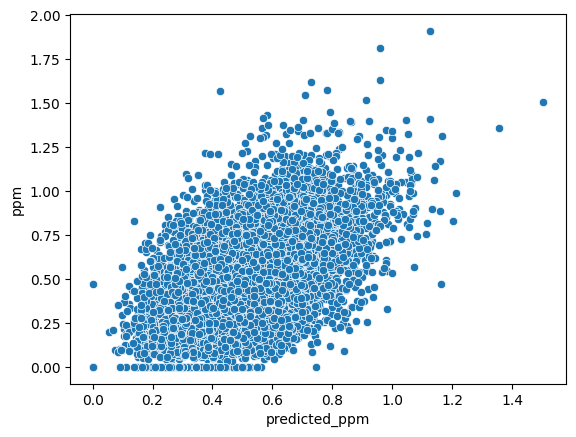

In [186]:
sns.scatterplot(predicted_df, x = 'predicted_ppm', y = 'ppm')

In [187]:
predicted_df[['predicted_ppm', 'ppm']].corr()

,predicted_ppm,ppm
predicted_ppm,1.000000,0.551081
ppm,0.551081,1.000000


In [188]:
pred_dropped = predicted_df.dropna()

In [189]:
r2_score(pred_dropped.ppm, pred_dropped.predicted_ppm)

0.2838849022758193

In [190]:
import seaborn as sns